In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
epsilon = 1e-8

In [2]:
class SVM(object):
    def linear_kernel(self, x, y, b=1.):
        return x @ y.T + b
    def rbf_kernel(self, x, y, sigma=1.):
        if np.ndim(x) == 1 and np.ndim(y) == 1:
            return np.exp(- np.linalg.norm(x - y) / (2 * sigma **2))
        elif np.ndim(x) > 1 and np.ndim(y) > 1:
            return np.exp(- np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], axis=2) / (2 * sigma **2))
        else:
            return np.exp(- np.linalg.norm(x - y, axis=1) / (2 * sigma ** 2))
    def __init__(self, C=1.0, tol=1e-3, eps=1e-3, kernel_func='rbf'):
        self.C = C
        self.tol = tol
        self.eps = eps
        self.b = 0.
        if kernel_func is 'linear':
            self.kernel_func = self.linear_kernel
        elif kernel_func is 'rbf':
            self.kernel_func = self.rbf_kernel
        else: 
            if callable(kernel_func) is True:
                self.kernel_func = kernel_func
            else:
                print('Error kernel function')

    def objective_function(self, alphas):
        calpha = alphas[:, np.newaxis]
        cY = self.Y[:, np.newaxis]
        return 0.5 * np.sum(calpha * calpha.T * cY * cY.T * self.K) - np.sum(alphas)
    
    def decision_function(self, x_test):
        k = self.kernel_func(self.X, x_test)
        return self.alpha * self.Y @ k + self.b
    
    def update_E(self):
        self.E = self.alpha * self.Y @ self.K + self.b - self.Y
    
    def step(self, i, j):
        if i == j:
            return 0
        alpha1, alpha2 = self.alpha[[i, j]] # old alpha1, old alpha2
        y1, y2 = self.Y[[i, j]]
        E1, E2 = self.E[[i, j]]
        s = y1 * y2
        K11, K12, K22 = self.K[i, i], self.K[i, j], self.K[j, j]
        eta = K11 + K22 - 2 * K12  ## 非正定核会出现eta < 0，K(x,y) = <phi(x),phi(y)>
        b = self.b # old b
        if y1 == y2:
            L = max(0, alpha2 + alpha1 - self.C)
            H = min(self.C, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, alpha2 - alpha1 + self.C)
        if L == H:
            return 0
        if eta > 0:
            a2 = alpha2 + y2 * (E1 - E2) / eta
            a2 = min(a2, H)
            a2 = max(a2, L)
        else:
            alpha_adj = self.alpha.copy()
            alpha_adj[j] = L
            Lobj = self.objective_function(alpha_adj)
            alpha_adj[j] = H
            Hobj = self.objective_function(alpha_adj)
            if Lobj < (Hobj - self.eps):
                a2 = L
            elif Lobj > (Hobj + self.eps):
                a2 = H
            else:
                a2 = alpha2
        if a2 < epsilon:
            a2 = 0.
        elif a2 > (self.C - epsilon):
            a2 = self.C
        if np.abs(a2 - alpha2) < self.eps * (a2 + alpha2 + self.eps): # ？
            return 0
        
        a1 = alpha1 + s * (alpha2 - a2)
        b1 = y1 * K11 * (alpha1 - a1) + y2 * K12 * (alpha2 - a2) - E1 + b
        b2 = y1 * K12 * (alpha1 - a1) + y2 * K22 * (alpha2 - a2) - E2 + b
        if a1 > 0 and a1 < self.C:
            b_new = b1
        elif a2 > 0 and a2 < self.C:
            b_new = b2
        else:
            b_new  = (b1 + b2) * 0.5
        self.b = b_new
        self.alpha[i] = a1
        self.alpha[j] = a2
        self.update_E()
        return 1
    
    def examineExample(self, j):
        alpha2 = self.alpha[j]
        E2 = self.E[j]
        y2 = self.Y[j]
        r = E2 * y2  # y_i * f_i - 1
        if (r < -self.tol and alpha2 < self.C) or (r > self.tol and alpha2 > 0): ## 检验tol-KKT条件，tol指KKT条件的精度
            if len(self.alpha[(self.alpha!=0) & (self.alpha != self.C)]) > 1:  ## 为什么要保证边界上的点大于1个？才选择最优的alpha2，一般来说更改边界上的点才会使得值最大，毕竟边界上的点对最终优化结果影响最大
#                 delta_E = np.abs(E2 - self.E)
                delta_E = np.abs((E2 - self.E) / self.K[j, :]) ##
                i = np.argmax(delta_E)
                if self.step(i, j):
                    return 1
            for i in np.roll(np.where((self.alpha != 0) & (self.alpha != self.C))[0],
                            np.random.choice(np.arange(self.N))):
                if self.step(i, j):
                    return 1
            for i in np.roll(np.arange(self.N), np.random.choice(np.arange(self.N))):
                if self.step(i, j):
                    return 1
        return 0
    
    def fit(self, X,Y):
        self.X, self.Y = X, Y
        self.N, self.M = X.shape
        self.alpha = np.zeros(self.N)
        self.K = self.kernel_func(X, X)
        self.update_E()
        
        numChanged = 0
        examineAll = True
        while numChanged > 0 or examineAll:
            numChanged = 0
            if examineAll is True:
                for j in range(self.N):
                    numChanged += self.examineExample(j)
            else:
                for j in np.where((self.alpha != 0) & (self.alpha != self.C))[0]:
                    numChanged += self.examineExample(j)
            if examineAll is True:
                examineAll = False
            elif numChanged == 0:
                examineAll = True
    
    def predict(self, Xs):
        return np.sign(self.decision_function(Xs))

In [3]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler

In [4]:
X, Y = make_moons(n_samples=500, shuffle=True, noise=0.1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y[Y==0] = -1

In [5]:
svm = SVM(C=1)
svm.fit(X, Y)

In [6]:
def plot_decision_boundary(model, resolution=100, colors=('b', 'k', 'r'), figsize=(14,6)):
    plt.figure(figsize=figsize)
    
    xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
    yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
    grid = [[model.decision_function(np.array([xr, yr])) for yr in yrange] for xr in xrange]
    grid = np.array(grid).reshape(len(xrange), len(yrange))
    
    # 左边
    plt.subplot(121)
    c_1_i = model.Y == -1
    plt.scatter(model.X[:,0][c_1_i], model.X[:,1][c_1_i], c='blueviolet', marker='.', alpha=0.8, s=20)
    c_2_i = np.logical_not(c_1_i)
    plt.scatter(model.X[:,0][c_2_i], model.X[:,1][c_2_i], c='teal', marker='.', alpha=0.8, s=20)
    plt.contour(xrange, yrange, grid.T, (0,), linewidths=(1,),
               linestyles=('-',), colors=colors[1])
    #右边
    plt.subplot(122)
    plt.contour(xrange, yrange, grid.T, (-1, 0, 1), linewidths=(1, 1, 1),
               linestyles=('--', '-', '--'), colors=colors)
    c_1_i = model.Y == -1
    plt.scatter(model.X[:,0][c_1_i], model.X[:,1][c_1_i], c='blueviolet', marker='.', alpha=0.6, s=20)
    c_2_i = np.logical_not(c_1_i)
    plt.scatter(model.X[:,0][c_2_i], model.X[:,1][c_2_i], c='teal', marker='.', alpha=0.6, s=20)
    
    mask1 = (model.alpha > epsilon) & (model.Y == -1)
    mask2 = (model.alpha > epsilon) & (model.Y == 1)
    plt.scatter(model.X[:,0][mask1], model.X[:,1][mask1],
               c='blueviolet', marker='v', alpha=1, s=20)
    plt.scatter(model.X[:,0][mask2], model.X[:,1][mask2],
               c='teal', marker='v', alpha=1, s=20)

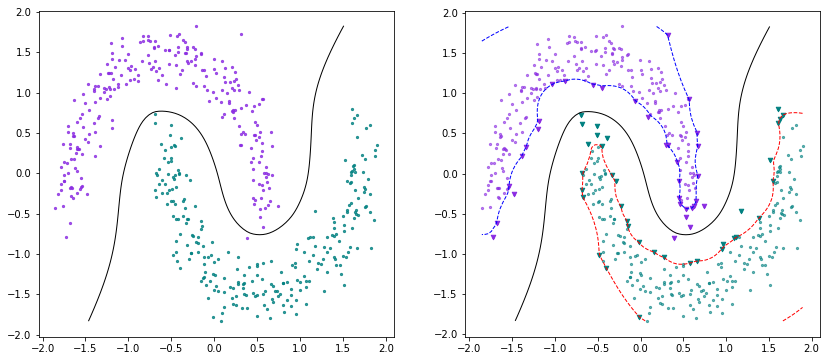

In [7]:
plot_decision_boundary(svm)

In [8]:
X, Y = make_moons(n_samples=500, shuffle=True, noise=0.2)
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y[Y==0] = -1

In [9]:
svm = SVM(C=1)
svm.fit(X, Y)

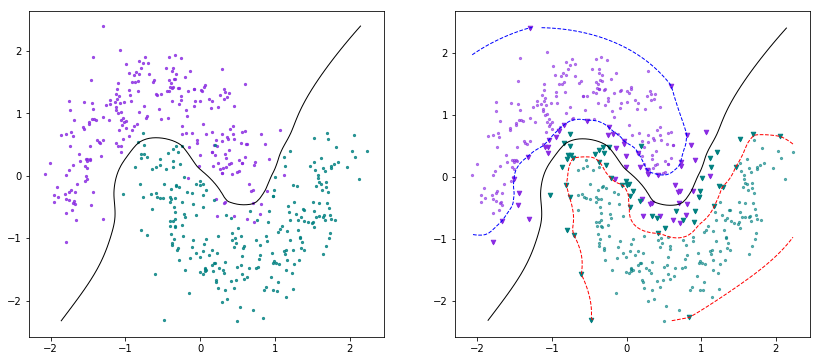

In [10]:
plot_decision_boundary(svm)

In [11]:
X, Y = make_circles(n_samples=500, shuffle=True, factor=0.3, noise=0.1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y[Y==0] = -1

In [12]:
svm = SVM(C=1)
svm.fit(X, Y)

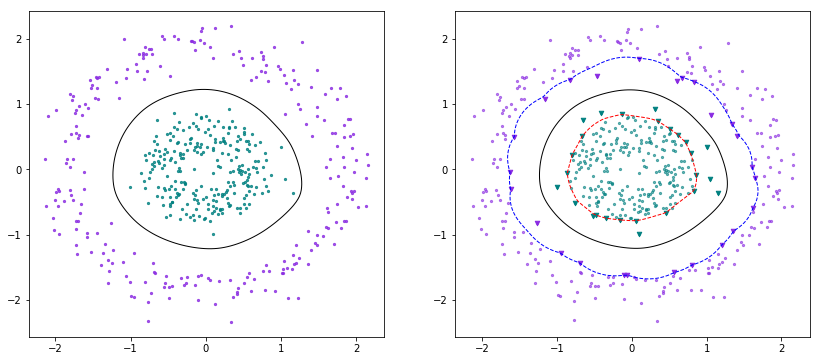

In [13]:
plot_decision_boundary(svm)

In [14]:
X, Y = make_circles(n_samples=500, shuffle=True, factor=0.3, noise=0.25)
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y[Y==0] = -1

In [15]:
svm = SVM(C=1)
svm.fit(X, Y)

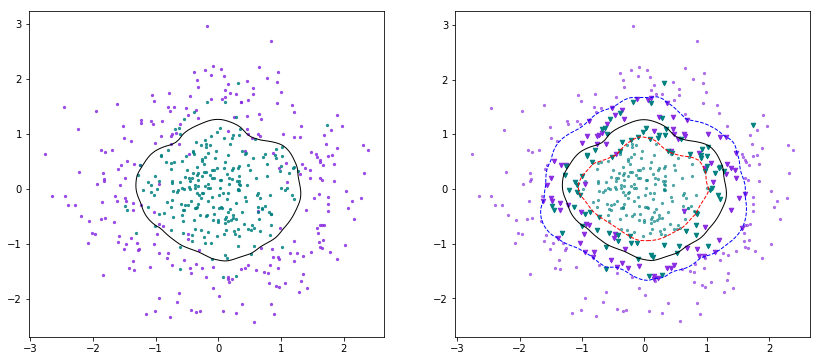

In [16]:
plot_decision_boundary(svm)